In [265]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor, plot_importance
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import sys
sys.path.insert(0, '../data_prep')
from sqlite_utils import select_statement_to_df, df_to_table, table_to_df
import shap

In [99]:
all_features_query = """

WITH BASE_TABLE AS (
    
      SELECT
      
        a.FILM_ID
        ,c.FILM_TITLE
        ,d.FILM_GENRE
        ,e.FILM_RATING
        ,f.FILM_RATING_SCALED
        ,CASE WHEN f.FILM_RATING_SCALED IS NOT NULL THEN 1 ELSE 0 END AS RATED
      
      FROM ALL_FILMS a
      LEFT JOIN CONTENT_TYPE b
      ON a.FILM_ID = b.FILM_ID
      LEFT JOIN FILM_TITLE c
      ON a.FILM_ID = c.FILM_ID
      LEFT JOIN FILM_GENRE d
      ON a.FILM_ID = d.FILM_ID
      LEFT JOIN FILM_LETTERBOXD_STATS e
      ON a.FILM_ID = e.FILM_ID
      LEFT JOIN PERSONAL_RATING f
      ON a.FILM_ID = f.FILM_ID
      
      WHERE CONTENT_TYPE = 'movie'
      
    )
   
    SELECT

      a.FILM_ID
      ,b.FILM_TITLE
      ,c.FILM_WATCH_COUNT
      ,g.TOP_250_POSITION AS FILM_TOP_250
      ,c.FILM_RATING
      ,COALESCE(1.0*c.FILM_LIKES_COUNT/c.FILM_WATCH_COUNT, 0.0) AS LIKES_PER_WATCH
      ,COALESCE(1.0*c.FILM_FAN_COUNT/c.FILM_WATCH_COUNT, 0.0) AS FANS_PER_WATCH
      ,d.FILM_RUNTIME
      ,f.FILM_YEAR
      ,e.ALL_FILM_GENRES
    
    FROM ALL_FEATURE_FILMS a
    LEFT JOIN FILM_TITLE b
    ON a.FILM_ID = b.FILM_ID
    LEFT JOIN FILM_LETTERBOXD_STATS c
    ON a.FILM_ID = c.FILM_ID
    LEFT JOIN FILM_RUNTIME d
    ON a.FILM_ID = d.FILM_ID
    LEFT JOIN FILM_GENRE e
    ON a.FILM_ID = e.FILM_ID
    LEFT JOIN FILM_YEAR f
    ON a.FILM_ID = f.FILM_ID
    LEFT JOIN FILM_LETTERBOXD_TOP_250 g
    ON a.FILM_ID = g.FILM_ID

"""

keyword_query = """

WITH BASE_TABLE AS (
    
    SELECT
    
        a.FILM_ID
        ,c.FILM_TITLE
        ,d.KEYWORD
        ,d.KEYWORD_ID
        ,e.FILM_RATING
        ,f.FILM_RATING_SCALED
        ,CASE WHEN f.FILM_RATING_SCALED IS NOT NULL THEN 1 ELSE 0 END AS RATED
    
    FROM ALL_FEATURE_FILMS a
    LEFT JOIN CONTENT_TYPE b
    ON a.FILM_ID = b.FILM_ID
    LEFT JOIN FILM_TITLE c
    ON a.FILM_ID = c.FILM_ID
    LEFT JOIN FILM_KEYWORDS d
    ON a.FILM_ID = d.FILM_ID
    LEFT JOIN FILM_LETTERBOXD_STATS e
    ON a.FILM_ID = e.FILM_ID
    LEFT JOIN PERSONAL_RATING f
    ON a.FILM_ID = f.FILM_ID
    
    WHERE b.CONTENT_TYPE = 'movie'
    
    )
    
, SCORE_TABLE AS (

    SELECT

    KEYWORD_ID
    ,KEYWORD
    ,AVG(FILM_RATING) AS MEAN_RATING
    ,AVG(FILM_RATING_SCALED) AS MY_MEAN_RATING
    ,AVG(FILM_RATING_SCALED) - AVG(FILM_RATING) AS MY_VARIANCE
    ,((AVG(FILM_RATING_SCALED) - AVG(FILM_RATING)) * ((SUM(RATED)+0.0)/COUNT(*))) AS VARIANCE_SCORE
    ,COUNT(*) AS KEYWORD_COUNT
    ,SUM(RATED) AS MY_RATING_COUNT
    ,(SUM(RATED)+0.0)/COUNT(*) AS SCALER
    
    FROM BASE_TABLE
    
    GROUP BY KEYWORD
    
    HAVING KEYWORD_COUNT >= 30
    AND SCALER >= 0.2
    AND MY_RATING_COUNT >= 3
    --ORDER BY MEAN_RATING DESC
    --ORDER BY KEYWORD_COUNT DESC
    --ORDER BY MY_VARIANCE DESC
    --ORDER BY VARIANCE_SCORE DESC
    --ORDER BY MY_MEAN_RATING DESC
    --ORDER BY VARIANCE_SCORE DESC
)

SELECT
    a.FILM_ID
    ,a.KEYWORD_ID
    ,b.KEYWORD
    
FROM FILM_KEYWORDS a
LEFT JOIN SCORE_TABLE b
ON a.KEYWORD_ID = b.KEYWORD_ID

WHERE b.KEYWORD_ID IS NOT NULL

"""

my_rating_query = """

    SELECT
         FILM_ID
        ,FILM_RATING_SCALED
    FROM PERSONAL_RATING

"""

director_rating_query = """

WITH BASE_TABLE AS (

    SELECT

        a.FILM_ID
        ,d.FILM_TITLE
        ,b.PERSON_ID
        ,e.PERSON_NAME AS DIRECTOR_NAME
        ,CASE WHEN c.FILM_ID IS NULL THEN 0 ELSE 1 END AS WATCHED
        ,f.FILM_RATING_SCALED
        ,CASE WHEN f.FILM_RATING_SCALED IS NULL THEN 0 ELSE 1 END AS RATED

    FROM ALL_FEATURE_FILMS a

    LEFT JOIN FILM_CREW b
    ON a.FILM_ID = b.FILM_ID

    LEFT JOIN WATCHED c
    ON a.FILM_ID = c.FILM_ID

    LEFT JOIN FILM_TITLE d
    ON a.FILM_ID = d.FILM_ID

    LEFT JOIN PERSON_INFO e
    ON b.PERSON_ID = e.PERSON_ID

    LEFT JOIN PERSONAL_RATING f
    ON a.FILM_ID = f.FILM_ID

    WHERE b.JOB = 'Director'
        
    )
      
, DIRECTOR_RATINGS AS (

	SELECT
      
       PERSON_ID
	  ,DIRECTOR_NAME
      ,COUNT(*) AS TOTAL_FILMS
      ,SUM(WATCHED) AS FILMS_WATCHED
      ,AVG(WATCHED) AS PERCENT_WATCHED
      ,AVG(FILM_RATING_SCALED) AS MEAN_RATING
      ,SUM(RATED) AS FILMS_RATED
      ,AVG(RATED) AS PERCENT_RATED
      
    FROM BASE_TABLE
    
    GROUP BY PERSON_ID, DIRECTOR_NAME

    HAVING TOTAL_FILMS >= 3
    AND FILMS_WATCHED > 1
    AND FILMS_RATED > 1
    AND MEAN_RATING NOT NULL
    AND PERCENT_RATED >= .2
    
 	)
, DIRECTOR_WATCH_STATS AS (

	SELECT
      
       PERSON_ID
	  ,DIRECTOR_NAME
      ,COUNT(*) AS TOTAL_FILMS
      ,AVG(WATCHED) AS PERCENT_WATCHED
      
    FROM BASE_TABLE
    
    GROUP BY PERSON_ID, DIRECTOR_NAME
    
 	)

, MEAN_RATING AS ( SELECT AVG(MEAN_RATING)AS MEAN_TOTAL_RATING FROM DIRECTOR_RATINGS )

, FILM_DIRECTOR_LEVEL AS (

	SELECT
		
		 a.FILM_ID
		,a.FILM_TITLE
		,a.PERSON_ID
		,a.DIRECTOR_NAME
		,COALESCE(b.MEAN_RATING, (SELECT 0.8*MEAN_TOTAL_RATING FROM MEAN_RATING)) AS DIRECTOR_MEAN_RATING
		,COALESCE(c.TOTAL_FILMS, 0) AS DIRECTOR_TOTAL_FILMS
		,COALESCE(c.PERCENT_WATCHED, 0) AS DIRECTOR_PERCENT_WATCHED
		
	 FROM BASE_TABLE a
	 LEFT JOIN DIRECTOR_RATINGS b 
	 ON a.PERSON_ID = b.PERSON_ID
	 LEFT JOIN DIRECTOR_WATCH_STATS c
	 ON a.PERSON_ID = c.PERSON_ID
	 
	 )
	 
SELECT
	
	 FILM_ID
	,AVG(DIRECTOR_MEAN_RATING) AS DIRECTOR_MEAN_RATING
	,AVG(DIRECTOR_TOTAL_FILMS) AS DIRECTOR_TOTAL_FILMS
	,AVG(DIRECTOR_PERCENT_WATCHED) AS DIRECTOR_PERCENT_WATCHED

FROM FILM_DIRECTOR_LEVEL

GROUP BY FILM_ID, FILM_TITLE

"""

top_actor_film_level_query = """

WITH BASE_TABLE AS (

    SELECT

        a.FILM_ID
        ,d.FILM_TITLE
        ,b.PERSON_ID
        ,e.PERSON_NAME AS ACTOR_NAME
        ,CASE WHEN c.FILM_ID IS NULL THEN 0 ELSE 1 END AS WATCHED
        ,CASE WHEN f.FILM_RATING_SCALED IS NOT NULL THEN 1 ELSE 0 END AS RATED
        ,f.FILM_RATING_SCALED

    FROM ALL_FEATURE_FILMS a
    
    LEFT JOIN FILM_CAST b
    ON a.FILM_ID = b.FILM_ID
    
    LEFT JOIN WATCHED c
    ON a.FILM_ID = c.FILM_ID
    
    LEFT JOIN FILM_TITLE d
    ON a.FILM_ID = d.FILM_ID

    LEFT JOIN PERSON_INFO e
    ON b.PERSON_ID = e.PERSON_ID

    LEFT JOIN PERSONAL_RATING f
    ON a.FILM_ID = f.FILM_ID

    WHERE e.PERSON_NAME IS NOT NULL
    
    )
    
, ACTOR_TABLE AS (

    SELECT

    PERSON_ID
    ,SUM(WATCHED) AS TOTAL_WATCHED
    
    FROM BASE_TABLE
    
    GROUP BY PERSON_ID
    
    HAVING TOTAL_WATCHED >= 20
)

SELECT
    
     a.FILM_ID
    ,a.PERSON_ID
    ,a.ACTOR_NAME
    ,1 AS ACTOR_IN_FILM
    
FROM BASE_TABLE a
INNER JOIN ACTOR_TABLE b
ON a.PERSON_ID = b.PERSON_ID

"""

def scale_col(df, column, suffix='', a=0, b=1):
    col_min = df[column].min()
    col_max = df[column].max()
    col_range = (col_max - col_min)
    df[column+suffix] = ((df[column] - col_min) / col_range) * (b - a) + a
    return df


In [137]:
def get_valid_cols(film_id, shap_df, min_shap_val=0.001):
    filmid_shap_df = shap_df[shap_df['FILM_ID']==film_id].reset_index(drop=True)
    valid_cols = []
    for col in filmid_shap_df.columns:
        shap_val = filmid_shap_df[col][0]
        if isinstance(shap_val, str):
            col_valid = False
        elif np.isnan(shap_val):
            col_valid = False
        elif abs(shap_val) < min_shap_val:
            col_valid = False
        elif col == 'BASE_VALUE':
            col_valid = True
        else:
            col_valid = True
        if col_valid:
            valid_cols.append(col)
    return valid_cols

def create_dual_df(film_id, pred_df, shap_df, valid_cols):
    film_title = pred_df[pred_df['FILM_ID']==film_id]['FILM_TITLE'].values[0]
    dual_df = pd.concat([pred_df[pred_df['FILM_ID']==film_id], shap_df[shap_df['FILM_ID']==film_id]])
    dual_df['FILM_TITLE'] = dual_df['FILM_TITLE'].fillna(film_title)
    dual_df['ALGO_SCORE'] = dual_df['ALGO_SCORE'].fillna(dual_df['ALGO_SCORE'].max())
    dual_df = dual_df[valid_cols]
    dual_df.insert(2, 'INFO', ['FEATURE_VALUE', 'SHAP_VALUE'])
    dual_df = dual_df.reset_index(drop=True)
    return dual_df

def return_comparison_df(film_ids, min_shap_val=0.001, decimal_places=3):
    pred_df = table_to_df(table_name='FILM_ALGO_SCORE')
    shap_df = table_to_df(table_name='FILM_SHAP_VALUES')
    valid_cols = [get_valid_cols(x, shap_df, min_shap_val=min_shap_val) for x in film_ids]
    valid_cols = list(set([col for valid_col_list in valid_cols for col in valid_col_list]))
    valid_cols = ['FILM_ID', 'FILM_TITLE', 'ALGO_SCORE'] + valid_cols
    valid_cols = [x for x in pred_df.columns if x in valid_cols]
    valid_cols.append('BASE_VALUE')
    all_dfs = []
    for n, film_id in enumerate(film_ids):
        dual_df = create_dual_df(film_id, pred_df, shap_df, valid_cols)
        melted_df = pd.melt(dual_df, id_vars=['FILM_ID', 'FILM_TITLE', 'INFO'])
        pivoted_df = melted_df.drop('FILM_ID', axis=1).pivot(index='variable', columns=['FILM_TITLE', 'INFO'], values='value').reset_index()
        pivoted_df.columns = [' '.join(col) for col in pivoted_df.columns]
        if n > 0:
            pivoted_df = pivoted_df.drop('variable ', axis=1)
        all_dfs.append(pivoted_df)
    comparison_df = pd.concat(all_dfs, axis=1)
    if len(film_ids) > 1:
        comparison_df['VAR'] = comparison_df[comparison_df.columns[4]] - comparison_df[comparison_df.columns[2]]
        comparison_df['ABS_VAR'] = comparison_df['VAR'].abs()
        comparison_df = comparison_df.sort_values('ABS_VAR', ascending=False)
    else:
        comparison_df = comparison_df.sort_values(comparison_df.columns[2], ascending=False)
    return comparison_df.round(decimal_places)

def min_max_scale(arr):
    arr = np.array(arr, dtype=np.float64)
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

In [4]:
eligible_watchlist_df = select_statement_to_df(all_features_query)
director_rating_df = select_statement_to_df(director_rating_query)
eligible_watchlist_df = eligible_watchlist_df.merge(director_rating_df, how='left', on='FILM_ID')
eligible_watchlist_df = pd.concat([eligible_watchlist_df, eligible_watchlist_df['ALL_FILM_GENRES'].str.get_dummies(sep='/')], axis=1).drop('ALL_FILM_GENRES', axis=1)
keyword_df = select_statement_to_df(keyword_query)
keyword_df['COUNT'] = 1
keyword_df_wide = pd.pivot_table(keyword_df, values='COUNT', index=['FILM_ID'], columns=['KEYWORD']).fillna(0).reset_index()
eligible_watchlist_df = eligible_watchlist_df.merge(keyword_df_wide, how='left', on='FILM_ID')
top_actor_film_level_df = select_statement_to_df(top_actor_film_level_query)
actor_lookup_df = top_actor_film_level_df.groupby(['PERSON_ID', 'ACTOR_NAME']).count().reset_index()
actor_lookup_dict = {id:name for id, name in zip(actor_lookup_df['PERSON_ID'], actor_lookup_df['ACTOR_NAME'])}
top_actor_film_level_df_wide = pd.pivot_table(top_actor_film_level_df, values='ACTOR_IN_FILM', index=['FILM_ID'], columns='PERSON_ID').fillna(0)
top_actor_film_level_df_wide.columns = [actor_lookup_dict.get(x, x) for x in top_actor_film_level_df_wide.columns]
eligible_watchlist_df['FILM_TOP_250'] = eligible_watchlist_df['FILM_TOP_250'].fillna(266)
eligible_watchlist_df.insert(4, 'FILM_IS_TOP_250', np.where(eligible_watchlist_df['FILM_TOP_250']<=250, 1, 0))
eligible_watchlist_df = eligible_watchlist_df.merge(top_actor_film_level_df_wide, how='left', on='FILM_ID').fillna(0)
eligible_watchlist_df['FILM_RATING'] = eligible_watchlist_df['FILM_RATING'].fillna(2.0)
eligible_watchlist_df = eligible_watchlist_df.fillna(0)
my_rating_df = select_statement_to_df(my_rating_query)
rating_features_df = eligible_watchlist_df.merge(my_rating_df, how='left', on='FILM_ID')
rating_features_df['I_VS_LB'] = rating_features_df['FILM_RATING_SCALED'] - rating_features_df['FILM_RATING']
rated_features = rating_features_df[rating_features_df['FILM_RATING_SCALED'].notnull()].reset_index(drop=True)
unrated_features = rating_features_df[rating_features_df['FILM_RATING_SCALED'].isnull()].reset_index(drop=True)
rating_features_df.head()

,FILM_ID,FILM_TITLE,FILM_WATCH_COUNT,FILM_TOP_250,FILM_IS_TOP_250,FILM_RATING,LIKES_PER_WATCH,FANS_PER_WATCH,FILM_RUNTIME,FILM_YEAR,...,Idris Elba,J.K. Simmons,Jack Angel,Alan Tudyk,Channing Tatum,Thomas Rosales Jr.,Mickie McGowan,Sherry Lynn,FILM_RATING_SCALED,I_VS_LB
0,f_01ZLI,Jumanji,1218740,266.0,0,3.63,0.186478,0.001299,104.0,1995,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.652174,-0.977826
1,f_01UTC,Fatal Attraction,137260,266.0,0,3.46,0.169751,0.001464,119.0,1987,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.904982,0.444982
2,f_020E4,Punch-Drunk Love,634109,266.0,0,3.98,0.327625,0.016601,96.0,2002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.048701,-0.931299
3,f_01TBi,Altered States,73346,266.0,0,3.67,0.279034,0.004636,102.0,1980,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.095018,0.425018
4,f_0t4EQ,Death to 2020,85215,266.0,0,2.72,0.109159,0.000023,71.0,2020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


In [5]:
def analyse_col(col_name):
    agg_df = rated_features.groupby(col_name).agg({'FILM_ID':'count', 'FILM_RATING':'mean', 'FILM_RATING_SCALED':'mean', 'I_VS_LB':'mean'})
    display(agg_df)
    all_titles = list(rated_features[rated_features[col_name] == 1]['FILM_TITLE'].values)
    display(', '.join(all_titles))
    if len(agg_df) <= 5:
        fig, ax = plt.subplots(2, 2, figsize=(10, 10))
        ax = ax.flatten()
        sns.histplot(rated_features, x='FILM_RATING_SCALED', hue=col_name, kde=True, ax=ax[0])
        sns.ecdfplot(rated_features, x='FILM_RATING_SCALED', hue=col_name, ax=ax[1])
        sns.histplot(rated_features, x='I_VS_LB', hue=col_name, kde=True, ax=ax[2])
        sns.ecdfplot(rated_features, x='I_VS_LB', hue=col_name, ax=ax[3])
    else:
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax = ax.flatten()
        sns.histplot(rating_features_df, x=col_name, kde=True, ax=ax[0])
        sns.ecdfplot(rating_features_df, x=col_name, ax=ax[1])

,FILM_ID,FILM_RATING,FILM_RATING_SCALED,I_VS_LB
horror,,,,
0,811,3.444032,3.429587,-0.014445
1,642,3.064206,3.266902,0.202696


"Altered States, The Skin I Live In, The Hunt, Ready or Not, The Nun, Paranormal Activity, The Faculty, Sea Fever, Spiral, I Know What You Did Last Summer, The Blob, Drag Me to Hell, Village of the Damned, House of Wax, Urban Legend, House of 1000 Corpses, Martyrs, Silent Hill, The Ghoul, Henry: Portrait of a Serial Killer, Frankenstein, The Invisible Man, Jennifer's Body, Psycho, Alien, The Thing, Get Out, Eraserhead, Jaws, It Follows, Carrie, Halloween, Friday the 13th, The Texas Chain Saw Massacre, The Exorcist, Friday the 13th Part 2, Creature from the Black Lagoon, Scream, Evil Dead, Audition, Orphan, The Autopsy of Jane Doe, Friday the 13th: A New Beginning, Gerald's Game, Suspiria, Hellbound: Hellraiser II, Candyman, Possum, The Babadook, The Brood, Midsommar, Hereditary, The Lighthouse, Us, Black Swan, Annihilation, Halloween, Alien: Covenant, Life, Apostle, Jigsaw, The Neon Demon, Don't Breathe, The Conjuring 2, The Purge: Election Year, Resident Evil: The Final Chapter, Terri

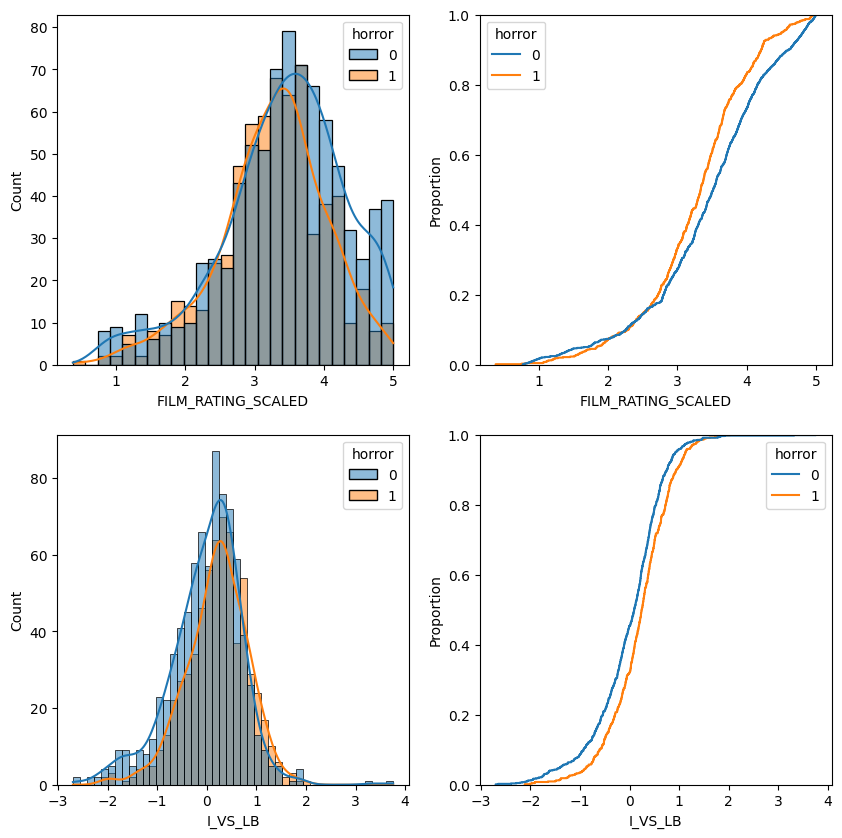

In [122]:
analyse_col('horror')

In [254]:
non_features = ['FILM_ID',
                'FILM_TITLE',
                # 'FILM_RATING',
                'FILM_RATING_SCALED',
                'FILM_RUNTIME',
                'FILM_WATCH_COUNT',
                'FILM_FAN_COUNT',
                'FILM_YEAR',
                'FILM_TOP_250',
                # 'DIRECTOR_MEAN_RATING',
                # 'DIRECTOR_TOTAL_FILMS',
                # 'DIRECTOR_PERCENT_WATCHED',
                'new jersey',
                'philadelphia, pennsylvania',
                'I_VS_LB'
                ]
model_features = [x for x in unrated_features.columns if x not in non_features]
delete_cols = []
for col in model_features:
    col_mean = rated_features[col].mean()
    if col_mean < .01:
        delete_cols.append(col)
print(delete_cols)
model_features = [x for x in model_features if x not in delete_cols]
target = 'I_VS_LB'
X_train = rated_features[model_features]
y_train = rated_features[[target]]
y_train = np.clip(y_train, np.percentile(y_train, 1), np.percentile(y_train, 99))
# y_train = np.square(y_train)
print('Data gathering complete!')
print('Scaling features...')
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
print('Features Scaled!')
print('Training model...')
valid_model_types = ['xgboost', 'decision_tree', 'linear_regression']
model_type = 'xgboost'
if model_type == 'xgboost':
    model = XGBRegressor(min_child_weight=5)
elif model_type == 'decision_tree':
    model = DecisionTreeRegressor(min_samples_leaf=5)
elif model_type == 'linear_regression':
    model = LinearRegression()
model.fit(X_train, y_train)
print('Model train complete!')
print('Making predictions...')
X_pred = unrated_features[model_features]
X_pred = scaler.transform(X_pred)
pred_df = unrated_features.copy()
pred_df[target+'_PRED'] = model.predict(X_pred)
# pred_df['FILM_RATING_PRED'] = np.sqrt(model.predict(X_pred))
print('Predictions complete!')
pred_df['FILM_RATING_PRED'] = pred_df['FILM_RATING'] + pred_df[target+'_PRED']
pred_df = scale_col(pred_df, 'FILM_RATING_PRED', a=0, b=5)
# pred_df = scale_col(pred_df, target+'_PRED', a=0, b=1)
model.score(X_train, y_train)

['FANS_PER_WATCH', 'none', 'tv-movie', 'western', '2000s', 'adventurer', 'amusement park', 'animal horror', 'antagonistic', 'apocalypse', 'archaeologist', 'audacious', 'awestruck', 'babysitter', 'baffled', 'basement', 'bible', 'biting', 'black magic', 'bold', 'car race', 'cautionary', 'chainsaw', 'clown', 'complex', 'computer', 'cruelty', 'desperate', 'disturbed', 'doppelgänger', 'dracula', 'duel', 'excited', 'existentialism', 'fantasy world', 'female villain', 'flying', 'futuristic', 'gas station', 'grave', 'guilt', 'hacker', 'homicide', 'hopeful', 'horrified', 'horror comedy', 'immortality', 'laboratory', 'lake', 'live action remake', 'maniac', 'mass murder', 'melodramatic', 'memory loss', 'mental institution', 'missing child', 'mission', 'morgue', 'murder mystery', 'murderer', 'mutation', 'nasa', 'new england', 'nostalgic', 'ominous', 'philosophical', 'philosophy', 'playful', 'powerful', 'prophecy', 'psychic', 'psychotic', 'psychotronic', 'puppet', 'race against time', 'reboot', 'ri

0.8898083368375895

0.3701509992758486

C:\Users\tom\AppData\Local\Temp\ipykernel_53296\375460187.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train)


<AxesSubplot:ylabel='Density'>

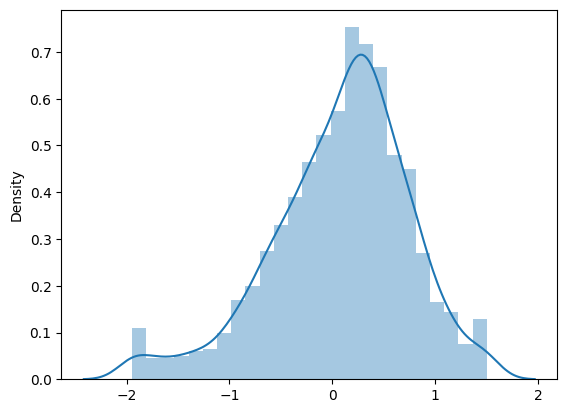

In [ ]:
sns.distplot(y_train)

C:\Users\tom\AppData\Local\Temp\ipykernel_53296\2780947421.py:2: RuntimeWarning: divide by zero encountered in log
  y_train_log = np.log(y_train_)
C:\Users\tom\AppData\Local\Temp\ipykernel_53296\2780947421.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(min_max_scale(y_train_), color='red')
C:\Users\tom\AppData\Local\Temp\ipykernel_53296\2780947421.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to u

<AxesSubplot:ylabel='Density'>

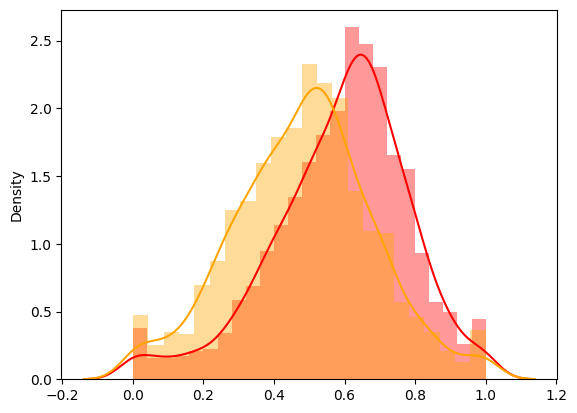

In [210]:
y_train_ = min_max_scale(y_train.iloc[:, 0].values)
y_train_log = np.log(y_train_)

y_train_squared = np.square(y_train_)

from scipy.stats import boxcox
y_train_boxcox, lambda_ = boxcox(1+y_train_)

from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
y_train_transformed_pt = pt.fit_transform(y_train_.reshape(-1, 1))

sns.distplot(min_max_scale(y_train_), color='red')
# sns.distplot(min_max_scale(y_train_squared), color='blue')
# sns.distplot(min_max_scale(y_train_log), color='green')
# sns.distplot(min_max_scale(y_train_boxcox), color='grey')
sns.distplot(min_max_scale(y_train_transformed_pt), color='orange')

In [255]:
# pred_df.sort_values(target+'_PRED', ascending=False).tail(50)
pred_df.sort_values('FILM_RATING_PRED', ascending=False).head(50)

,FILM_ID,FILM_TITLE,FILM_WATCH_COUNT,FILM_TOP_250,FILM_IS_TOP_250,FILM_RATING,LIKES_PER_WATCH,FANS_PER_WATCH,FILM_RUNTIME,FILM_YEAR,...,Jack Angel,Alan Tudyk,Channing Tatum,Thomas Rosales Jr.,Mickie McGowan,Sherry Lynn,FILM_RATING_SCALED,I_VS_LB,I_VS_LB_PRED,FILM_RATING_PRED
4,f_02aq2,Schindler's List,1542503,13.0,1,4.53,0.311431,0.013258,195.0,1993,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.354134,5.000000
1701,f_01Uc4,Cowboy Bebop: The Movie,111619,266.0,0,4.09,0.333626,0.004363,115.0,2001,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.743005,4.956774
17511,f_00Msm,Incendies,401775,44.0,1,4.42,0.382381,0.029375,131.0,2010,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.377706,4.926932
2270,f_02b0u,Star Trek II: The Wrath of Khan,136011,266.0,0,3.93,0.272610,0.009271,112.0,1982,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.838800,4.902495
7361,f_0Ao48,National Theatre Live: Prima Facie,18009,266.0,0,4.56,0.475262,0.020379,114.0,2022,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.194215,4.890165
51,f_0070w,Kill Bill: Vol. 1,2956449,266.0,0,4.20,0.383491,0.020451,111.0,2003,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.551988,4.888282
3,f_02axi,Seven Samurai,454346,4.0,1,4.61,0.395487,0.027558,207.0,1954,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.105526,4.857457
3199,f_018H4,Witness for the Prosecution,108504,83.0,1,4.37,0.337149,0.008737,116.0,1957,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.338852,4.851814
597,f_01Km4,Serenity,135298,266.0,0,3.66,0.218680,0.004279,119.0,2005,...,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,1.043033,4.846894
27,f_023um,Boogie Nights,623679,266.0,0,4.21,0.327964,0.015960,156.0,1997,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.475973,4.832472


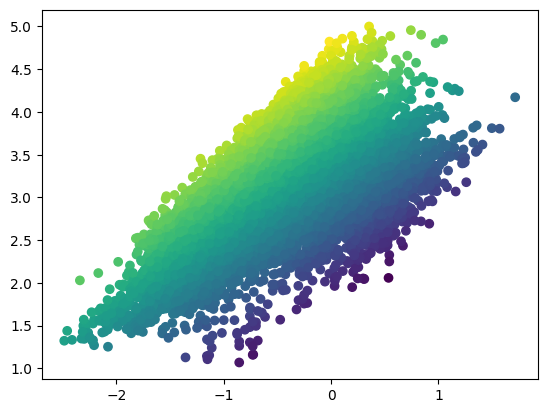

In [259]:
plt.scatter(data=pred_df[pred_df['FILM_RATING']>0], x='I_VS_LB_PRED', y='FILM_RATING_PRED', c='FILM_RATING')

(array([0.07777403, 0.04586673, 0.1017045 , 0.22135685, 0.36493967,
        0.5464124 , 0.73586195, 0.49057463, 0.21936264, 0.09372767]),
 array([-1.94969032, -1.60457487, -1.25945942, -0.91434396, -0.56922851,
        -0.22411306,  0.12100239,  0.46611785,  0.8112333 ,  1.15634875,
         1.50146421]),
 [<matplotlib.patches.Polygon at 0x1a398374520>])

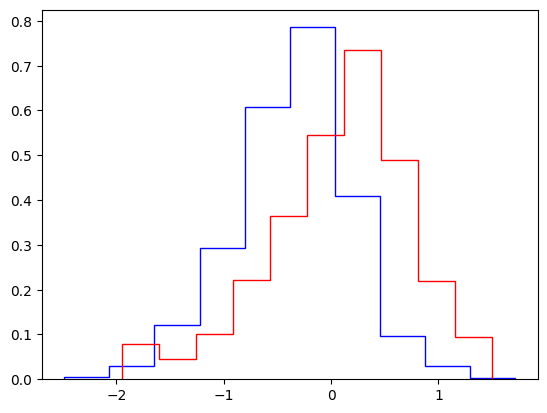

In [257]:
plt.hist(pred_df['I_VS_LB_PRED'], color='blue', density=True, histtype='step')
plt.hist(y_train, color='red', density=True, histtype='step')

In [258]:
pred_df.sort_values('I_VS_LB_PRED', ascending=False).head(50)

,FILM_ID,FILM_TITLE,FILM_WATCH_COUNT,FILM_TOP_250,FILM_IS_TOP_250,FILM_RATING,LIKES_PER_WATCH,FANS_PER_WATCH,FILM_RUNTIME,FILM_YEAR,...,Jack Angel,Alan Tudyk,Channing Tatum,Thomas Rosales Jr.,Mickie McGowan,Sherry Lynn,FILM_RATING_SCALED,I_VS_LB,I_VS_LB_PRED,FILM_RATING_PRED
5722,f_0aX7k,400 Days,3821,266.0,0,2.19,0.057315,0.000523,91.0,2015,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.714591,4.171880
12698,f_09oig,Soul Searcher,16,266.0,0,0.00,0.125000,0.000000,98.0,2005,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.621920,2.242077
14089,f_0JPJU,The Jack in the Box Rises,1904,266.0,0,1.90,0.098214,0.000000,92.0,2024,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.569849,3.804343
16270,f_02Hms,InSight,176,266.0,0,0.00,0.096591,0.000000,92.0,2011,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.499009,2.138166
10053,f_01jrQ,Pumaman,3980,266.0,0,1.98,0.118844,0.001005,97.0,1980,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.497149,3.810515
13102,f_03Xuk,Super Fly T.N.T.,309,266.0,0,0.00,0.126214,0.006472,87.0,1973,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.467958,2.111916
17211,f_0r4bK,The Fight Machine,150,266.0,0,0.00,0.126667,0.000000,104.0,2022,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.439015,2.087447
9695,f_03PGs,This Man Is Dangerous,102,266.0,0,0.00,0.186275,0.009804,92.0,1953,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.423762,2.074552
12816,f_01ojC,Sting of the Black Scorpion,171,266.0,0,0.00,0.157895,0.000000,84.0,2002,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.415180,2.067296
5327,f_022sE,I Know Who Killed Me,15440,266.0,0,1.84,0.089119,0.000972,105.0,2007,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.410100,3.618564


In [260]:
final_df = pd.concat([pred_df, rated_features], axis=0).reset_index(drop=True)
print('Calculating SHAP values...')
if model_type == 'xgboost' or model_type == 'decision_tree':
    explainer = shap.TreeExplainer(model, X_train)
elif model_type == 'linear_regression':
    explainer = shap.LinearExplainer(model, X_train)
# shap_values = explainer.Explainer(X_pred)
shap_values = explainer.shap_values(X_pred)
explainer_df = pd.DataFrame(shap_values, columns=model_features)
explainer_df.insert(0, 'FILM_ID', pred_df['FILM_ID'])

Calculating SHAP values...


 99%|===================| 17554/17793 [00:40<00:00]        

In [267]:
explainer2 = shap.TreeExplainer(model)
explanation = explainer2(X_pred)
shap_values2 = explainer2.shap_values(X_pred)

In [274]:
X_pred.shape

(17793, 128)

In [276]:
shap.initjs()
shap.force_plot(explainer2.expected_value, shap_values2[0, :], X_pred[0])

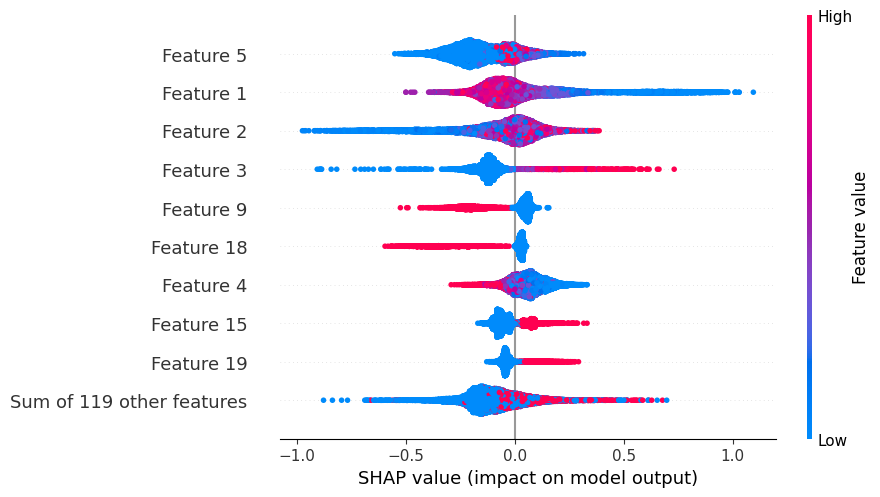

In [262]:
shap.plots.beeswarm(explanation)

In [31]:
tmp_film_id = 'f_0J1hQ'
tmp = explainer_df[explainer_df['FILM_ID']==tmp_film_id].drop('FILM_ID', axis=1)
tmp2 = tmp.loc[:, (abs(tmp) > 0.01).any(axis=0)].T.reset_index()
tmp2.columns = ['col_name', 'col_shap']
tmp3 = unrated_features[unrated_features['FILM_ID']==tmp_film_id].T.reset_index()
tmp3.columns = ['col_name', 'col_val']
tmp4 = tmp3.merge(tmp2, how='inner', on='col_name')
tmp4.sort_values('col_shap')

,col_name,col_val,col_shap
6,DIRECTOR_PERCENT_WATCHED,0.0,-0.232895
10,horror,1,-0.080770
9,fantasy,0,-0.020217
7,action,0,-0.014972
11,romance,0,0.033440
5,DIRECTOR_TOTAL_FILMS,3.0,0.038525
4,DIRECTOR_MEAN_RATING,2.818663,0.074879
8,comedy,1,0.093393
2,FANS_PER_WATCH,0.0,0.124652
1,LIKES_PER_WATCH,0.21831,0.148641


In [57]:
# explainer_df.columns = [x+'_SHAP' if x != 'FILM_ID' else x for x in explainer_df.columns]
explainer_df

,FILM_ID,FILM_WATCH_COUNT,FILM_TOP_250,FILM_IS_TOP_250,LIKES_PER_WATCH,FANS_PER_WATCH,FILM_YEAR,DIRECTOR_MEAN_RATING,DIRECTOR_TOTAL_FILMS,DIRECTOR_PERCENT_WATCHED,...,Josh Brolin,Michael Fassbender,Idris Elba,Jack Angel,Alan Tudyk,Channing Tatum,Thomas Rosales Jr.,Bob Bergen,Mickie McGowan,Sherry Lynn
0,f_0t4EQ,-0.019838,-0.005042,0.0,-0.022399,-0.011638,0.110354,-0.078481,-0.068545,0.014448,...,0.0,0.0,0.0,0.0,0.0,0.004492,0.0,0.0,0.0,0.0
1,f_02aNK,0.208930,0.012750,0.0,-0.149646,-0.046005,-0.078431,-0.065758,-0.001143,0.022205,...,0.0,0.0,0.0,0.0,0.0,0.002232,0.0,0.0,0.0,0.0
2,f_02aNq,0.046703,0.034336,0.0,-0.095538,0.013687,-0.081971,-0.080194,0.058052,0.029084,...,0.0,0.0,0.0,0.0,0.0,0.002232,0.0,0.0,0.0,0.0
3,f_02axi,0.148218,0.051009,0.0,-0.128719,0.079946,-0.240951,-0.068009,0.043284,0.104414,...,0.0,0.0,0.0,0.0,0.0,0.002232,0.0,0.0,0.0,0.0
4,f_02aq2,0.136600,0.054942,0.0,-0.031003,0.008218,-0.026860,0.164467,0.064547,-0.028197,...,0.0,0.0,0.0,0.0,0.0,0.002189,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17597,f_0C68A,-0.005803,-0.009070,0.0,-0.207320,-0.164194,0.027844,-0.088288,-0.009307,-0.216528,...,0.0,0.0,0.0,0.0,0.0,0.004237,0.0,0.0,0.0,0.0
17598,f_01YJ2,0.002140,-0.006303,0.0,0.027306,-0.070538,-0.166474,-0.099079,0.009098,-0.488773,...,0.0,0.0,0.0,0.0,0.0,0.004209,0.0,0.0,0.0,0.0
17599,f_06nHy,-0.127744,-0.006720,0.0,0.060671,-0.039522,-0.027592,-0.098783,0.016951,-0.268967,...,0.0,0.0,0.0,0.0,0.0,0.004175,0.0,0.0,0.0,0.0
17600,f_00efo,-0.032945,-0.004046,0.0,0.198527,-0.179757,-0.048621,-0.112062,-0.005434,-0.279363,...,0.0,0.0,0.0,0.0,0.0,0.004209,0.0,0.0,0.0,0.0


In [45]:
pred_df

,FILM_ID,FILM_TITLE,FILM_WATCH_COUNT,FILM_TOP_250,FILM_IS_TOP_250,FILM_RATING,LIKES_PER_WATCH,FANS_PER_WATCH,FILM_RUNTIME,FILM_YEAR,...,Alan Tudyk,Channing Tatum,Thomas Rosales Jr.,Bob Bergen,Mickie McGowan,Sherry Lynn,FILM_RATING_SCALED,I_VS_LB,I_VS_LB_PRED,FILM_RATING_PRED
0,f_0t4EQ,Death to 2020,85215,266.0,0,2.72,0.109159,0.000023,71.0,2020,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,-0.242576,3.324543
1,f_02aNK,The Godfather,2353523,10.0,1,4.55,0.398753,0.031550,175.0,1972,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,-0.176708,4.626953
2,f_02aNq,The Godfather Part II,1264933,5.0,1,4.59,0.363767,0.023963,202.0,1974,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,-0.323162,4.553822
3,f_02axi,Seven Samurai,423024,4.0,1,4.61,0.394800,0.027091,207.0,1954,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,-0.053516,4.752801
4,f_02aq2,Schindler's List,1411196,13.0,1,4.52,0.310770,0.012549,195.0,1993,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.389202,4.995109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17597,f_0C68A,Riceboy Sleeps,17376,266.0,0,4.12,0.397617,0.020661,117.0,2022,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,-0.658969,4.000255
17598,f_01YJ2,The Dinner Game,63265,266.0,0,3.80,0.226144,0.005580,80.0,1998,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,-1.143607,3.447490
17599,f_06nHy,A Wolf at the Door,34397,266.0,0,3.85,0.292613,0.006483,98.0,2013,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,-0.507931,3.918531
17600,f_00efo,Zindagi Na Milegi Dobara,51388,266.0,0,3.91,0.343835,0.032926,154.0,2011,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,-0.874650,3.707823


In [58]:
def visualise_shap_for_feature(feature_name):
    if feature_name in [x for x in explainer_df.columns if x != 'FILM_ID']:
        values = pred_df[feature_name]
        shaps = explainer_df[feature_name]
        plt.scatter(x=values, y=shaps)
    else:
        print('Choose a Feature Used in the model')

In [63]:
[x for x in explainer_df.columns if x != 'FILM_ID']

['FILM_WATCH_COUNT',
 'FILM_TOP_250',
 'FILM_IS_TOP_250',
 'LIKES_PER_WATCH',
 'FANS_PER_WATCH',
 'FILM_YEAR',
 'DIRECTOR_MEAN_RATING',
 'DIRECTOR_TOTAL_FILMS',
 'DIRECTOR_PERCENT_WATCHED',
 'action',
 'adventure',
 'animation',
 'comedy',
 'crime',
 'drama',
 'family',
 'fantasy',
 'history',
 'horror',
 'music',
 'mystery',
 'none',
 'romance',
 'science-fiction',
 'thriller',
 'war',
 'western',
 '2000s',
 'adventurer',
 'aftercreditsstinger',
 'aggressive',
 'alien life-form',
 'amusement park',
 'android',
 'anthropomorphism',
 'anti hero',
 'anxious',
 'apocalypse',
 'archaeologist',
 'army',
 'artificial intelligence (a.i.)',
 'astronaut',
 'awestruck',
 'babysitter',
 'based on comic',
 'basement',
 'bible',
 'black magic',
 'body horror',
 'brutality',
 'car race',
 'clown',
 'complex',
 'computer',
 'corpse',
 'creature',
 'cruelty',
 'cyberpunk',
 'cyborg',
 'death game',
 'decapitation',
 'demon',
 'demonic possession',
 'depressing',
 'disturbed',
 'dracula',
 'duel',
 'du

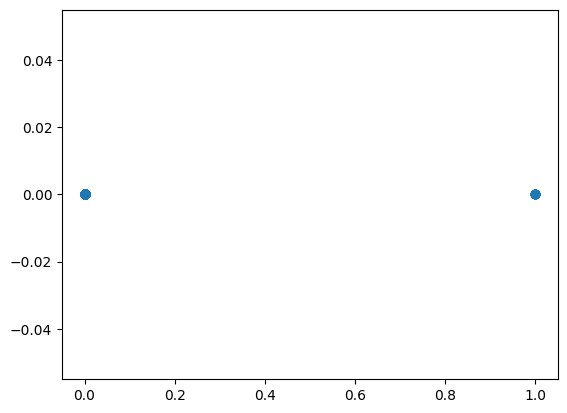

In [74]:
visualise_shap_for_feature('body horror')

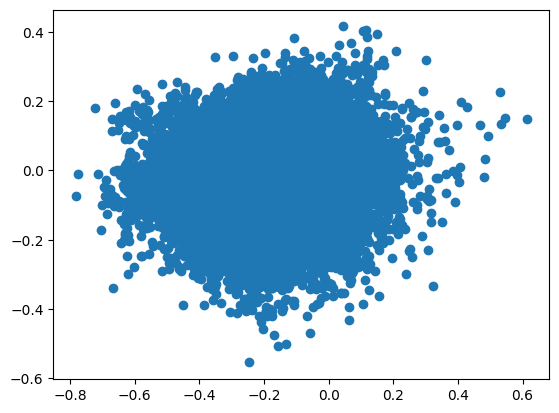

In [34]:
plt.scatter(data=explainer_df, x='FILM_WATCH_COUNT', y='LIKES_PER_WATCH')

In [252]:
pred_df.sort_values('FILM_RATING_PRED')

,FILM_ID,FILM_TITLE,FILM_WATCH_COUNT,FILM_TOP_250,FILM_IS_TOP_250,FILM_RATING,LIKES_PER_WATCH,FANS_PER_WATCH,FILM_RUNTIME,FILM_YEAR,...,Jack Angel,Alan Tudyk,Thomas Rosales Jr.,Bob Bergen,Mickie McGowan,Sherry Lynn,FILM_RATING_SCALED,I_VS_LB,I_VS_LB_PRED,FILM_RATING_PRED
6651,f_04rmU,Sunday Lovers,118,266.0,0,0.00,0.084746,0.000000,125,1980,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,-1.795272,0.000000
11764,f_00M24,The Treatment,185,266.0,0,0.00,0.070270,0.000000,86,2006,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,-1.785493,0.001418
13428,f_00LvO,A Further Gesture,84,266.0,0,0.00,0.071429,0.000000,96,1997,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,-1.737286,0.008407
14026,f_04hfY,Two Tickets to Broadway,246,266.0,0,0.00,0.105691,0.000000,106,1951,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,-1.731155,0.009296
12230,f_0hhJq,The Brawler,178,266.0,0,0.00,0.073034,0.000000,95,2014,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,-1.588463,0.029983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,f_01skk,Inception,3060548,266.0,0,4.19,0.404516,0.017288,148,2010,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.767369,0.979001
27,f_02aGY,Terminator 2: Judgment Day,860837,266.0,0,4.28,0.306057,0.012814,137,1991,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.732608,0.987010
117,f_0b8wK,Blade Runner 2049,1593560,266.0,0,4.13,0.378853,0.025117,164,2017,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.910138,0.991001
104,f_04VZ8,Interstellar,3036075,266.0,0,4.32,0.452177,0.052233,169,2014,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.771972,0.998516


In [40]:
ex

0.0405559266593475

In [39]:

# import ipdb; ipdb.set_trace()
try:
    ex = explainer.expected_value[0]
except:
    ex = explainer.expected_value
explainer_df.insert(1, 'BASE_VALUE', ex)
explainer_df['PREDICTION'] = explainer_df.sum(axis=1)
explainer_df = explainer_df.merge(pred_df[['FILM_ID', 'ALGO_SCORE']], how='left', on='FILM_ID')
explainer_df['SCALER'] = explainer_df['ALGO_SCORE'] / explainer_df['PREDICTION']
explainer_df = explainer_df.drop('FILM_ID', axis=1).mul(explainer_df['SCALER'], axis=0).drop(['ALGO_SCORE', 'SCALER'], axis=1) 
explainer_df.insert(0, 'FILM_ID', pred_df['FILM_ID'])
explainer_df = explainer_df.loc[:, (explainer_df != 0).any(axis=0)]
print('SHAP values calculated!')

C:\Users\tom\AppData\Local\Temp\ipykernel_60388\1129709933.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  explainer_df['PREDICTION'] = explainer_df.sum(axis=1)


KeyError: "['ALGO_SCORE'] not in index"

In [235]:
X_train

array([[ 0.93282623,  0.07302188, -0.08215985, ..., -0.09325048,
        -0.10319204, -0.10319204],
       [-0.51551018,  0.07302188, -0.08215985, ..., -0.09325048,
        -0.10319204, -0.10319204],
       [ 0.17525549,  0.07302188, -0.08215985, ..., -0.09325048,
        -0.10319204, -0.10319204],
       ...,
       [-0.61828158,  0.07302188, -0.08215985, ..., -0.09325048,
        -0.10319204, -0.10319204],
       [-0.69483497,  0.07302188, -0.08215985, ..., -0.09325048,
        -0.10319204, -0.10319204],
       [-0.55662786,  0.07302188, -0.08215985, ..., -0.09325048,
        -0.10319204, -0.10319204]])